<a href="https://colab.research.google.com/github/Francesca-2803/Covid/blob/main/FER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='#009acd'>**FACIAL EXPRESSION RECOGNITION**</font>

**FRANCESCA GHIDINI**

**5007699**


The dataset used for the analysis is a `CSV` file containing information regarding **48x48 pixel grayscale images** of faces. It is provided by `Kaggle` at the following link: [FER dataset](https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge).


## <font color='#009acd'>**Libraries**</font>

In [ ]:
%%capture
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from PIL import Image, ImageOps
import random
import math

pio.templates.default = "plotly_white"
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import sklearn
from sklearn import metrics
from sklearn import preprocessing

!pip install torch torchvision d2l
!pip install torch d2l
!pip install opencv-python
import torch
from torchvision import transforms, datasets
from torch.utils import data
from torch import nn
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

%pip install matplotlib==3.1.3
from d2l import torch as d2l
d2l.use_svg_display()
%matplotlib inline
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow as show
import random
import cv2
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive #to upload the files from Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DF = pd.read_csv('/content/drive/MyDrive/PROGETTO_ADVANCE/fer2013.csv')

## <font color='#009acd'>**Data Exploration**</font>

The CSV file contains 35.887 rows and 3 columns. For each row the information provided is:
- **Emotion**: integers from 0 to 6 that corresponds to the following facial expressions:
 *  0: Angry
 *  1: Disgust
 *  2: Fear
 *  3: Happy
 *   4: Sad
 *   5: Surprise
 *   6: Neutral
- **Pixels**: 2.304 integers that represent the grayscale value for each pixel of an image 48x48. The values of the pixels range from 0 to 255. The Figure below shows some examples of correspondence between values and pixel's colour. 

- **Usage**: the dataset from which the picture belongs:
 *   Training
 *   Test
 *   ValidationCSV


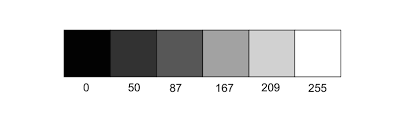

In [ ]:
from IPython.display import display, Image
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/grayscale.png'))

In [ ]:
DF.shape 

(35887, 3)

In [ ]:
DF["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  
                           x=DF["Usage"], texttemplate="%{y}", textfont_size=20))
fig.update_traces(opacity=0.75, marker_color='#009acd')
fig.update_layout(title_text='Amount of pictures in each dataset',
    xaxis_title_text='Dataset',
    yaxis_title_text='Count')
fig.update_yaxes(exponentformat= "none")
fig.show()

The images contained in the training set are 28.709, while in the validation set and in the test set there are 3.589 pictures which correspond almost to 10% of the entire dataset. 

In [ ]:
DF["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

From the following plot it is possible to notice that the classes are quite unbalanced:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  
                           x=DF["emotion"], texttemplate="%{y}", textfont_size=20))
fig.update_traces(opacity=0.75, marker_color='#009acd')
fig.update_layout(title_text='Amount of pictures for each emotion', 
    xaxis_title_text='Dataset',
    yaxis_title_text='Count',bargap=0.2)
fig.update_xaxes(
    ticktext=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    tickvals=[0,1,2,3,4,5,6])
fig.update_yaxes(exponentformat= "none")
fig.show()

Since class 1 (`Disgust`) has far fewer observations than the others it will be removed from the dataset. The reason is that keeping this class would cause a decrease in the accuracy of the model because the pictures are not enough to train the model properly to recognise this facial expression.

In [ ]:
DF = DF[DF["emotion"] != 1]
DF.reset_index(drop=True, inplace=True)

In the following plots are shown the number of pictures, for each class in each dataset:

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  
                           x=DF[(DF["Usage"]== "Training")]["emotion"], texttemplate="%{y}", textfont_size=20))
fig.update_traces(opacity=0.75, marker_color='#009acd')
fig.update_layout(title_text='Amount of pictures for each emotion TRAINING SET', 
    xaxis_title_text='Dataset',
    yaxis_title_text='Count',bargap=0.2)
fig.update_xaxes(
    ticktext=["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    tickvals=[0,2,3,4,5,6])
fig.update_yaxes(exponentformat= "none")
fig.show()

In [ ]:
DF[(DF["Usage"]== "Training")]["emotion"].value_counts()

3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
Name: emotion, dtype: int64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  
                           x=DF[(DF["Usage"]== "PublicTest")]["emotion"], texttemplate="%{y}", textfont_size=20))
fig.update_traces(opacity=0.75, marker_color='#009acd')
fig.update_layout(title_text='Amount of pictures for each emotion VALIDATION SET', 
    xaxis_title_text='Dataset',
    yaxis_title_text='Count',bargap=0.2)
fig.update_xaxes(
    ticktext=["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    tickvals=[0,2,3,4,5,6])
fig.update_yaxes(exponentformat= "none")
fig.show()

In [ ]:
DF[(DF["Usage"]== "PublicTest")]["emotion"].value_counts()

3    895
4    653
6    607
2    496
0    467
5    415
Name: emotion, dtype: int64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  
                           x=DF[(DF["Usage"]== "PrivateTest")]["emotion"], texttemplate="%{y}", textfont_size=20))
fig.update_traces(opacity=0.75, marker_color='#009acd')
fig.update_layout(title_text='Amount of pictures for each emotion TEST SET', 
    xaxis_title_text='Dataset',
    yaxis_title_text='Count',bargap=0.2)
fig.update_xaxes(
    ticktext=["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    tickvals=[0,2,3,4,5,6])
fig.update_yaxes(exponentformat= "none")
fig.show()

In [ ]:
DF[(DF["Usage"]== "PrivateTest")]["emotion"].value_counts()

3    879
6    626
4    594
2    528
0    491
5    416
Name: emotion, dtype: int64

Some of the classes are pretty unbalanced like the third class (`Happy`) that has more than two times the pictures in the class `Surprise`. 
For that reason, it will be taken a random subsample of the training set for some expression to balance the classes in the training set. 
However, to avoid losing too much information removing too many pictures the classes will not be perfectly balanced but 4712 observations (mean of the dimensions of the different classes) will be kept for the larger classes.

In [ ]:
def balance(DataFrame, final_length, df, emotion):
  ind = DataFrame.index[(DataFrame["emotion"] == emotion) &  (DataFrame["Usage"]== df)].tolist() #rows of observations of a particular expression and of a particular dataset
  to_remove = random.sample(ind, (len(ind)- final_length)) #random sample of the rows 
  new_DF = DF.drop(to_remove) #remove the random sample of rows from the dataset
  new_DF.reset_index(drop=True, inplace=True) #reset indexes
  return new_DF

In [ ]:
DF = balance(DF, 4712, "Training", 3) #balancing class 3

In [ ]:
DF = balance(DF, 4712, "Training", 6) #balancing class 6

In [ ]:
DF = balance(DF, 4712, "Training", 4) #balancing class 4

From the following plot, it is possible to observe the new counts of pictures in each class of the training set. The class `Surprise` is the smaller class, therefore I will expect slightly worse performance in recognising the pictures of this class. 

In [ ]:
DF[(DF["Usage"]== "Training")]["emotion"].value_counts()

4    4712
6    4712
3    4712
2    4097
0    3995
5    3171
Name: emotion, dtype: int64

In [ ]:
fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count",  
                           x=DF[(DF["Usage"]== "Training")]["emotion"], texttemplate="%{y}", textfont_size=20))
fig.update_traces(opacity=0.75, marker_color='#009acd')
fig.update_layout(title_text='Amount of pictures for each emotion TRAINING SET', 
    xaxis_title_text='Dataset',
    yaxis_title_text='Count',bargap=0.2)
fig.update_xaxes(
    ticktext=["Angry", "Fear", "Happy", "Sad", "Surprise", "Neutral"],
    tickvals=[0,2,3,4,5,6])
fig.update_yaxes(exponentformat= "none")
fig.show()

In [ ]:
DF.shape

(32466, 3)

In [ ]:
DF["Usage"].value_counts()

Training       25399
PrivateTest     3534
PublicTest      3533
Name: Usage, dtype: int64

## <font color='#009acd'>**Image Creation**</font>

Now that the classes are balanced, it is possible to create a folder for each set. Within each folder, a folder will be created for every expression containing the pictures generated from the pixels that are in the CSV file:

In [ ]:
DF_pixels= pd.DataFrame(DF.pixels.str.split(" ").tolist(), dtype= int) #convert the pixel's list to dataframe 5 rows × 2304 columns (number of pixels for each image)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised



In [ ]:
DF_pixels

,0,1,2,3,4,5,6,7,8,9,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,70,80,82,72,58,58,60,63,54,58,...,159,182,183,136,106,116,95,106,109,82
1,151,150,147,155,148,133,111,140,170,174,...,105,108,95,108,102,67,171,193,183,184
2,231,212,156,164,174,138,161,173,182,200,...,104,138,152,122,114,101,97,88,110,152
3,24,32,36,30,32,23,19,20,30,41,...,174,126,132,132,133,136,139,142,143,142
4,4,0,0,0,0,0,0,0,0,0,...,12,34,31,31,31,27,31,30,29,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32461,50,36,17,22,23,29,33,39,34,37,...,216,215,216,217,221,222,220,223,221,216
32462,178,174,172,173,181,188,191,194,196,199,...,147,141,136,118,66,7,0,0,0,0
32463,17,17,16,23,28,22,19,17,25,26,...,190,179,193,193,194,170,148,154,133,113
32464,30,28,28,29,31,30,42,68,79,81,...,30,27,27,26,28,35,35,35,30,28


In [ ]:
DF_images = DF_pixels.values.astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [ ]:
DF_images = DF_images.reshape(-1,1,48,48).astype('float32') #An array of size 48x48 is created for each picture

In [ ]:
w, h = 48, 48 #width and height of each image (in pixel)

### <font color='#009acd'>**Folders creation**</font>

The folders "training", "validation" and "test" are created and then within each of them a folder for each expression is created:

In [ ]:
#Function that creates a folder in a specifi path
def create_folder(whatever):
    try:
        os.makedirs(whatever)
    except OSError:
        pass

    os.chdir(whatever)

In [ ]:
# Creating training test e validation
#for i in ["Training", "Test", "Validation"]:
#  path = "/content/drive/MyDrive/PROGETTO_ADVANCE/" + str(i)
#  create_folder(path)

In [ ]:
#Creating a folder for each expression in each dataset's folder
#for i in ["Angry", "Fear","Happy","Sad","Surprise","Neutral"]:
#  create_folder("/content/drive/MyDrive/PROGETTO_ADVANCE/Training/" + str(i))
#  create_folder("/content/drive/MyDrive/PROGETTO_ADVANCE/Test/" + str(i))
#  create_folder("/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/" + str(i))

At this point, for each row of the `csv` the 48x48 image is saved in the corresponding folder:

In [ ]:
# for i in range(DF.shape[0]):
#   emotion = DF.iloc[i][0]
#   dataset = DF.iloc[i][2]
#   pixels = DF_images[i]
#   data = np.zeros((h, w), dtype=np.uint8)
#   data[0:48, 0:48] = DF_images[i]
#   img = Image.fromarray(data, "L")
# 
#   if dataset == "Training" and emotion == 0:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Angry/" + str(emotion) + "_" + str(i) + ".png"
#     img.save(path_name)
# 
#   elif dataset == "Training" and emotion == 2:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Fear/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "Training" and emotion == 3:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Happy/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "Training" and emotion == 4:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Sad/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "Training" and emotion == 5:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Surprise/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "Training" and emotion == 6:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Neutral/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
#   
#   elif dataset == "PrivateTest" and emotion == 0:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Angry/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PrivateTest" and emotion == 2:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Fear/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PrivateTest" and emotion == 3:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Happy/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PrivateTest" and emotion == 4:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Sad/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PrivateTest" and emotion == 5:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Surprise/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PrivateTest" and emotion == 6:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Neutral/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PublicTest" and emotion == 0:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/Angry/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PublicTest" and emotion == 2:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/Fear/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PublicTest" and emotion == 3:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/Happy/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PublicTest" and emotion == 4:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/Sad/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PublicTest" and emotion == 5:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/Surprise/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)
# 
#   elif dataset == "PublicTest" and emotion == 6:
#     path_name = "/content/drive/MyDrive/PROGETTO_ADVANCE/Validation/Neutral/" + str(emotion) + "_" + str(i)+ ".png"
#     img.save(path_name)

## <font color='#009acd'>**Data preparation**</font>

An important step in order to train a model is **DATA AUGMENTATION**. This technique allows to user to increase the number of pictures used to train the model by applying some alteration to the images. In this case, I perform the following data augmentation:


*   **RandomVerticalFlip**: Vertically flip the given image randomly (with probability 0.05). The selected probability is chosen to be so low because vertically flipped images of people are not very popular. 
*   **RandomHorizontalFlip**: Horizontally flip the given image randomly (with probability 0.5)
*   **RandomPerspective**: Perform a random perspective transformation of the given image with probability 0.4
*   **ToTensor**: Transform each PIL image to a tensor defined as [Channels, Height, Width]
*   **Normalize**: Normalize a tensor image with mean and standard deviation. Since the provided images are grayscales, the mean and the standard deviation are given as [(0,5), (0,5)]. Normalization is important for getting data within a range and improve the training making it faster because it reduces the skewness. 








In [ ]:
data_transform = transforms.Compose([                      
    transforms.RandomVerticalFlip(0.05),
    transforms.RandomHorizontalFlip(0.5), 
    transforms.RandomPerspective(p=0.4), 
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

In order to import grayscale images, a loader is created and then it is used in the `ImageFolder` function that imports the images, applying data augmentation. 

In [ ]:
def gray_reader(image_path):
    im = Image.open(image_path)
    im2 = ImageOps.grayscale(im)
    im.close()
    return im2      # return PIL Image


In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/PROGETTO_ADVANCE/Training',
                                  transform= data_transform, 
                                  loader=gray_reader
                                  )
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/PROGETTO_ADVANCE/Test',
                                  transform= data_transform, 
                                  loader=gray_reader
                                  )
validation_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/PROGETTO_ADVANCE/Validation',
                                  transform= data_transform, 
                                  loader=gray_reader
                                  )

## <font color='#009acd'>**Showing Pictures**</font>

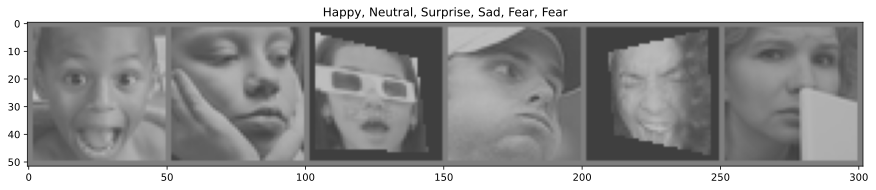

In [ ]:
batch_size = 6 #ONLY for showing the pictures in a clear way
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, shuffle=True)
train_iter = iter(train_dataloader)
X, y = next(train_iter)

i = 0
title = ""
for x in y:
  title = title + str(train_dataset.classes[x]) 
  i += 1
  if i != 6:
    title=title +  ", "


def imshow(img, title):
    img = img / 4 + 0.5    # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
      plt.title(title)
      

pic = torchvision.utils.make_grid(X, nrow=6)
imshow(pic, title=title)

From the images shown above, it is possible to notice that almost all the faces are more or less centred and occupy approximately the same amount of space in each image. At the same time, it is possible to observe how some of them are transformed due to data augmentation.
Another important aspect to take into consideration is the fact that expressions are not always something objective, therefore some pictures may be interpretable differently depending on who is watching them. This will probably affect the accuracy of the neural network.

The images below show other features of the pictures in the datasets:
- Sometimes there is some text on the faces

- Some pictures do not show real people but also drawings, dolls, cartoons etc.

- Some faces are not frontal, but are in profile

- In some pictures, people partially cover their faces with their hands

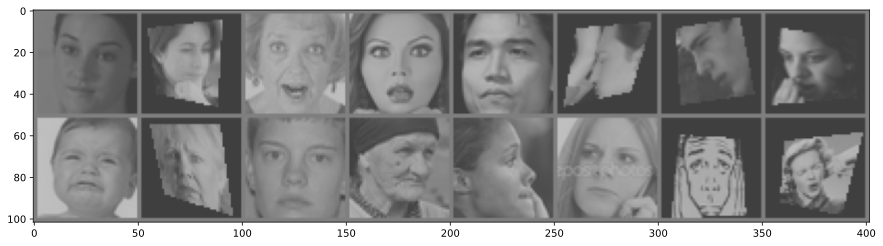

In [ ]:
batch_size = 16 #ONLY for showing the pictures in a clear way
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, shuffle=True)
train_iter = iter(train_dataloader)
X, y = next(train_iter)

pic = torchvision.utils.make_grid(X, nrow=8)
imshow(pic, title = None)

At this point, the datasets are converted into `DataLoader` class to load and iterate over the tensors. 
Moreover, it allows us to define how many samples are contained in each batch. The batch size used in this case is 64 in order to avoid losing too much information, even if, considering the final size of the data frame, it will lead to a long time for training the model. 
The other parameters are:


*   `shuffle`: if `True`, it shuffles the data at every epoch
*   `num_workers`: defines the number of sub-process used for data loading





In [ ]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle = True, 
                                               num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle = False, 
                                              num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle = False, 
                                                    num_workers=2)

In [ ]:
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)
validation_iter = iter(validation_dataloader)

In [ ]:
X, y = next(train_iter)

In [ ]:
X.shape #batch size, channel, height, width

torch.Size([64, 1, 48, 48])

### <font color='#009acd'>**Definition of dimensions after different layers**</font>

To create a neural network it is essential to define the input argument of each layer. The following functions are created to define the dimension of each tensor after being processed in each layer. This function will be useful to define the input of the first linear layer after several convolutional layers and maxpool layers. 

In [ ]:
# dim_iniz = [batch size, channels, width, height]
# conv = [channels, output_channels, kernel size, stride, padding]

#Convolutional layer
def InputCon(dim_iniz, conv):
  batch = dim_iniz[0]
  channel = conv[1]
  new_dim = ((dim_iniz[2] - conv[2] + 2* conv[4])/conv[3]) + 1
  new_dim=math.floor(new_dim)
  x = [batch, channel, new_dim, new_dim]
  return x

#Maxpool(kernel, stride) #default Maxpool(2,2)
def max_pool(dim_iniz, kernel=2, stride = 2):
  size = math.floor(((dim_iniz[2]-kernel)/stride) + 1)
  x = [dim_iniz[0], dim_iniz[1], size , size ]
  return x

#Input for linear layes
def Linear(dim_iniz, out):
  return [dim_iniz[1] * dim_iniz[2] * dim_iniz[3], out]



In the following sections, some neural networks have been defined and trained in order to perform classification of the images. 

## <font color='#009acd'>**Franet0**</font>

The first model trained is defined as **Franet0**. It is a feedforwad neural network. 

It is composed of 4 linear layers, 4 dropouts layers and 4 ReLU activation functions. 

The first layer has as input 2304 because it is given by the product between: channels (1), height (48) and width (48) of the images. 
The final layer has as output argument 6 because it is the number of classes to define. 
The activation function used in all the hidden layers is the ReLU. It is defined as: 
$$f(x) = max(0, x)$$  
It has been chosen because it is a simple and fast activation function that usually leads to better results. 
The choice of using 4 dropout layers is for trying to avoid overfitting which will be a huge issue of this whole project. In fact, this layer dropouts some neurons during the training. 

In [ ]:
class FraNet0(Module):   
  def __init__(self):
    super(FraNet0, self).__init__()
    self.linear_layers = Sequential(
        Linear(2304, 1152), 
        nn.Dropout(p=0.5), 
        nn.ReLU(),
        nn.Linear(1152, 576), 
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(576, 72), 
        nn.Dropout(p=0.5),
        nn.ReLU(),   
        nn.Linear(72, 6)
        )

    # Defining the forward pass    
  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
# defining the model
model0 = FraNet0()

The loss function used in the model is the **Cross-Entropy Loss** function that is usually implemented for classification tasks. It quantifies the distance between the expected output and the output produced by the model. It is used both to evaluate if the model is performing well and to evaluate the gradient used for optimizing the weights. 

Another important parameter to define for training the model is the optimizer. In this case, the optimizer used is **Adam** which can reach good results faster than other optimization algorithms. 

In [ ]:
#Loss Function
loss_function = torch.nn.CrossEntropyLoss()

#Optimizer
optimizer_FraNet = torch.optim.Adam(params =  model0.parameters(), lr = 10**(-4)) 

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

model0.to(device)

cuda


FraNet0(
  (linear_layers): Sequential(
    (0): Linear(in_features=2304, out_features=1152, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=1152, out_features=576, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=576, out_features=72, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=72, out_features=6, bias=True)
  )
)

Then, the model has been trained for 150 epochs. Since the validation set was available, the training function performs both training and evaluation of loss and accuracy on both the training set and the validation set at each epoch. 

An `early stopping criterion` was defined so that: if the difference of the training accuracy between two consecutive epochs is lower than 0.000001, the algorithm stops before reaching the 150 epochs.



In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model0.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500 == 0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model0(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model0.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model0(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7883115946796138 Validation Loss: 1.7659582261528288 
 Train Accuracy: 18.870821685893144  Val Accuracy: 25.728842343617323
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.7318710686277683 Validation Loss: 1.6960418437208449 
 Train Accuracy: 25.81597700696878  Val Accuracy: 29.21030285876026
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.6884832301127821 Validation Loss: 1.6600338029009956 
 Train Accuracy: 28.276703807236505  Val Accuracy: 30.540617039343335
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.6648806741916262 Validation Loss: 1.6476476511784963 
 Train Accuracy: 29.87912909957085  Val Accuracy: 32.60684970280215
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

The algorithm stops at iteration 123 due to the `early_stopping_criterion` defined above. The final accuracy on the training set is 62.91%, while the one on the validation set is 40.19%. As it is possible to notice from the plots below the loss continues decreasing as the epochs increase, while the validation loss, after an initial decrease, starts increasing approximately when it reaches the 50th epoch. 

From the plot of the accuracy, it is possible to observe that the accuracy on the validation set at the beginning is higher than the one of the training, but then it starts oscillating (almost at the 21st epoch) around the value of 40% without any huge increase or decrease. On the other hand, the accuracy of the training keep increasing until reaching a final value of 62.91% at the 123rd epoch.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model0(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 39.53027730616865


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 63.8529075947872


The model is tested both on the test set and on the training set (to check if everything is correct). The result obtained on the test set is an accuracy of 39.53% that is also slightly smaller than the one of the validation set. The test applied on the training set reaches an accuracy of 63.85%. 
These results show that:

1) The final accuracy of the test is not a satisfying result because it is a small value. Anyway, since the classes are 6, this accuracy result is better than assigning a random class to each image.

2) The training accuracy is much higher than the one of the test set suggesting that the model tends to overfit the training data.

In [ ]:
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

The following chart provides useful metrics for each expression class:


*   $Precision = \frac{true \ positive}{total \ predicted \ positives}$  

*   $Recall = \frac{true \ positive}{total \ predicted \ positives}$  

*   $F_1 \ score = 2 * \frac{precision * recall}{precision + recall}$  

Considering the $F_1$ score of the different classes it is possible to observe that the classes with the lower values are `Angry` and `Fear` which were the second and third smallest classes in the training set. 

The confusion matrix represented below provides further insights on the misclassification, showing that a lot of errors derive from the fact that the algorithm assigned the class `sad` to the wrong pictures.



In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.30      0.24      0.27       491
        Fear       0.29      0.27      0.28       528
       Happy       0.55      0.54      0.55       879
     Neutral       0.37      0.35      0.36       626
         Sad       0.30      0.39      0.34       594
    Surprise       0.51      0.50      0.50       416

    accuracy                           0.40      3534
   macro avg       0.39      0.38      0.38      3534
weighted avg       0.40      0.40      0.39      3534



In [ ]:
def Confusion_matrix(Y, Y_hat):
  cf_matrix = sklearn.metrics.confusion_matrix(Y, Y_hat)
    
  group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(6,6)
  plt.figure(figsize = (10,5))
  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap="Blues", linewidths=5, annot_kws={"size": 11}, xticklabels=class_names, yticklabels=class_names)
    
  sns.set(font_scale=1)


  ax.set_title('Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Expression')
  ax.set_ylabel('Real Expression');

  ## Display the visualization of the Confusion Matrix.
  plt.show()

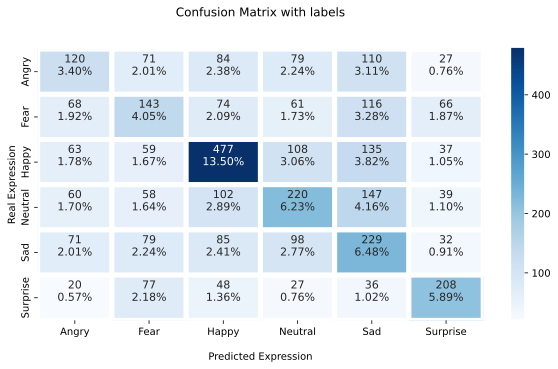

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

## <font color='#009acd'>**Franet1**</font>

Trying to achieve better results, the new neural network `Franet1` is a convolutional neural network. This kind of neural network converts the images into a form that is easier to process and is also able to capture the spatial dependencies into an image. 

The convolutional neural networks implemented in this project are made up of two parts: 

- **Feature extraction** performed by a CNN
- **Classification** done using a fully connected neural network

`Franet1`has 3 convolutional layers. 
For each of them are defined:
- `input size`: number of channels of the input. In the first layer it is 1 since the images are grayscales. 
- `output size`: number of channels after the convolution
- `kernel_size`: dimension of the filter that is convolved with the input 
- `stride`: stride of the kernel 
- `padding`: amount of padding applied to the input

Each of them is followed by a MaxPool layer that downsample the input along its spatial dimensions. This kind of layer is implemented in order to avoid overfitting. 

The activation function used in the CNN part is the ReLU for the same reason explained before. 

Finally, the classification part is characterized by 4 linear layers, 3 dropout layers and ReLU activation function. 


In [ ]:
conv1 = InputCon([64, 1, 48,48], [1, 6, 5, 1, 1])
print(conv1)
maxpool1 = max_pool(conv1)
print(maxpool1)
conv2 = InputCon(maxpool1, [6, 16, 5, 2, 2])
print(conv2)
maxpool2 = max_pool(conv2)
print(maxpool2)
conv3 = InputCon(maxpool2, [16, 64, 3, 1, 1])
print(conv3)
maxpool3 = max_pool(conv3)
print(maxpool3)
Linear1 = Linear(maxpool3, 288)
print(Linear1)

[64, 6, 46, 46]
[64, 6, 23, 23]
[64, 16, 12, 12]
[64, 16, 6, 6]
[64, 64, 6, 6]
[64, 64, 3, 3]
[576, 288]


In [ ]:
class FraNet(Module):   
  def __init__(self):
    super(FraNet, self).__init__()
    
    self.cnn_layers = Sequential(
        Conv2d(1, 6, kernel_size=5, stride=1, padding = 1),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(6, 16, 5,  stride=2, padding = 2),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(16, 64, kernel_size=3, stride=1, padding = 1),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2)
        )

    self.linear_layers = Sequential(
        Linear(576, 288), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 
        nn.Linear(288, 144), 
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        nn.Linear(144, 48), 
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        nn.Linear(48, 6)
        )

    # Defining the forward pass    
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
# defining the model
model = FraNet()

In [ ]:
#Loss function
loss_function = torch.nn.CrossEntropyLoss()
#Adam optimizer
optimizer_FraNet = torch.optim.Adam(params =  model.parameters(), lr = 10**(-4)) 

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

model.to(device)

cuda


FraNet(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=576, out_features=288, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=288, out_features=144, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=144, out_features=48, bias=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
    (9): Linear(in_fe

In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500 == 0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7835258939104057 Validation Loss: 1.7656189032963343 
 Train Accuracy: 18.276310090948463  Val Accuracy: 23.03990942541749
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.7561913848824104 Validation Loss: 1.7439813252006258 
 Train Accuracy: 21.705578959801567  Val Accuracy: 25.417492216246817
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.7328380499438616 Validation Loss: 1.7254866723503386 
 Train Accuracy: 24.575770699633843  Val Accuracy: 27.45542032267195
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.7120388175738548 Validation Loss: 1.7050862801926476 
 Train Accuracy: 26.58766093153274  Val Accuracy: 28.9838664024908
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

Also in this case the algorithm stops due to the `Early stopping criterion`. At the 41st epoch, the model achieves an accuracy on the trainining set equal to 42.32% which is lower than the one of `Franet0`. The accuracy on the validation set is 42.91% which is higher than the one of `Franet0`. Differently from before, the accuracy and the loss of training and of the validation do not differentiate much during the training phase, they almost overlap showing that the model does not overfit the data. 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 42.81267685342388


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 42.28512933580062


In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.32      0.29      0.30       491
        Fear       0.28      0.11      0.16       528
       Happy       0.67      0.55      0.60       879
     Neutral       0.36      0.60      0.45       626
         Sad       0.35      0.34      0.34       594
    Surprise       0.48      0.61      0.54       416

    accuracy                           0.43      3534
   macro avg       0.41      0.42      0.40      3534
weighted avg       0.43      0.43      0.42      3534



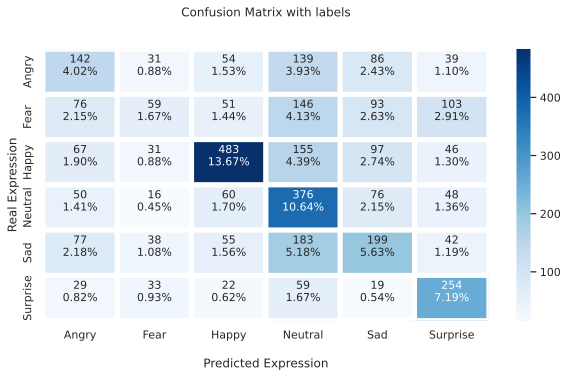

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

Also the results of the test are coherent with the ones of the training and the validation. The accuracy is 42.81% which is higher than the one of `Franet0` but still not so good.  In this case, looking at the $F_1 scores$ of the classes, it is possible to notice that the model is really bad in recognizing the class `Fear` that most of the time is misclassified with `Neutral` and `Suprise`. For all the other classes, the performances are improved with respect to `Franet0`. 

## <font color='#009acd'>**Franet2**</font>





In order to increase the accuracy, `Franet1` is modified. I also add a convolutional layer, some `BatchNorm` layers and 1 additional linear layer in the classification part of the model.  The `BatchNorm` layer is used in order to normalize the layers' input.

In [ ]:
conv1 = InputCon([64, 1, 48,48], [1, 6, 3, 1, 2])
print(conv1)

conv2 = InputCon(conv1, [6, 64, 3, 2, 1])
print(conv2)

maxpool2 = max_pool(conv2)
print(maxpool2)

conv3 = InputCon(maxpool2, [64, 128, 3, 1, 1])
print(conv3)

conv4 = InputCon(conv3, [128, 256, 3, 1,0])
print(conv4)

maxpool3 = max_pool(conv4)
print(maxpool3)

Linear1 = Linear(maxpool3, 2048)
print(Linear1)

[64, 6, 50, 50]
[64, 64, 25, 25]
[64, 64, 12, 12]
[64, 128, 12, 12]
[64, 256, 10, 10]
[64, 256, 5, 5]
[6400, 2048]


In [ ]:
class FraNet2(Module):   
  def __init__(self):
    super(FraNet2, self).__init__()
    self.cnn_layers = Sequential(
    Conv2d(1, 6, kernel_size=3, stride=1, padding = 2),
    BatchNorm2d(6),
    ReLU(inplace=True),


    Conv2d(6, 64, kernel_size=3, stride=2, padding = 1),
    BatchNorm2d(64),
    ReLU(inplace=True),
    MaxPool2d(kernel_size=2, stride=2),


    Conv2d(64, 128, 3,  stride=1, padding = 1),
    BatchNorm2d(128),
    ReLU(inplace=True),


    Conv2d(128, 256, 3,  stride=1, padding = 0),
    ReLU(inplace=True),
    MaxPool2d(kernel_size=2, stride=2),
    )

    self.linear_layers = Sequential(
        Linear(6400, 2048), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 

        nn.Linear(2048, 1024), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 

        nn.Linear(1024, 256), 
        nn.Dropout(p=0.5),
        nn.ReLU(), 

        nn.Linear(256, 64),
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        
        nn.Linear(64, 6)
    )

    # Defining the forward pass    
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
# defining the model
model2 = FraNet2()

In [ ]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss()

#Optimizer
optimizer_FraNet = torch.optim.Adam(params =  model2.parameters(), lr = 10**(-4))

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

model2.to(device)

cuda


FraNet2(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6400, out_features=2048, bias=True)
    (1): Dropout(p=0.5, inplac

In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model2.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500==0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model2(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model2.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model2(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7652916310716336 Validation Loss: 1.691089934536389 
 Train Accuracy: 20.7803456829009  Val Accuracy: 29.57826210019813
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.6077135978477728 Validation Loss: 1.4962327161005564 
 Train Accuracy: 32.78869246820741  Val Accuracy: 40.13586187376168
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.4811839645995901 Validation Loss: 1.4132801805223738 
 Train Accuracy: 39.588172762707195  Val Accuracy: 43.33427681856779
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.4037311686676757 Validation Loss: 1.341366922216756 
 Train Accuracy: 43.83243434780897  Val Accuracy: 47.38182847438438
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Also in this case the algorithm stops earlier at the 38th epoch. The final accuracy of the training is 74.54%, while the one of the validation is 55.19%. From the plots it is possible to notice a trend of the lines similar to the one of `Franet0`: at the beginning, the loss function of the training is smaller, then around the 4th epochs the loss of the validation starts increasing overcoming the training loss that continues decreasing. 

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model2(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 56.87606112054329


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 75.61321311862672


In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.49      0.42      0.46       491
        Fear       0.48      0.31      0.38       528
       Happy       0.76      0.76      0.76       879
     Neutral       0.49      0.59      0.54       626
         Sad       0.41      0.49      0.45       594
    Surprise       0.72      0.74      0.73       416

    accuracy                           0.57      3534
   macro avg       0.56      0.55      0.55      3534
weighted avg       0.57      0.57      0.57      3534



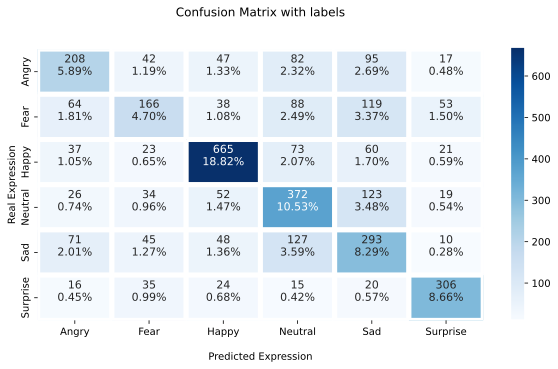

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

The result achieved on the test set is more than 10% higher than the ones of the previous models. The final accuracy is 56.88% and also the results of the $F_1 score$ are increased, now none of them is lower than 36% therefore for none of the images it would be better to assign the class randomly. Anyway, also in this case, most of the misclassification errors delas with the class `fear`. 

## <font color='#009acd'>**Franet3**</font>


The new model will be obtained by increasing MaxPool layers in order to decrease the overfitting reached in `Franet2`. At the same time, also another convolutional layer has been added to increase the accuracy. 

So, at the end `Franet3` will be defined as follow:



*   Features Extraction step: 
    *   5 Convolutional Layers
    *   5 BatchNorm Layers
    *   3 MaxPool layers
    *   ReLU activation function after each convolutional layer


*   Classification step:
    *  5 linear layers
    *  4 dropout layers
    *  ReLU activation function



In [ ]:
conv1 = InputCon([64, 1, 48,48], [1, 6, 3, 1, 2])
print(conv1)
conv2 = InputCon(conv1, [6, 32, 5, 1, 1])
print(conv2)
maxpool1 = max_pool(conv2)
print(maxpool1)
conv3 = InputCon(maxpool1, [32, 64, 5, 1, 1])
print(conv3)
conv4 = InputCon(conv3, [64, 128, 3, 1, 0])
print(conv4)
maxpool2 = max_pool(conv4)
print(maxpool2)
conv5 = InputCon(maxpool2, [128, 256, 3, 1, 0])
print(conv5)
maxpool3 = max_pool(conv5)
print(maxpool3)
Linear1 = Linear(maxpool3, 2048)
print(Linear1)

[64, 6, 50, 50]
[64, 32, 48, 48]
[64, 32, 24, 24]
[64, 64, 22, 22]
[64, 128, 20, 20]
[64, 128, 10, 10]
[64, 256, 8, 8]
[64, 256, 4, 4]
[4096, 2048]


In [ ]:
class FraNet3(Module): #runno
  def __init__(self):
    super(FraNet3, self).__init__()
    self.cnn_layers = Sequential(
        Conv2d(1, 6, kernel_size=3, stride=1, padding = 2),
        BatchNorm2d(6),
        ReLU(inplace=True),

        Conv2d(6, 32, kernel_size=5, stride=1, padding = 1),
        BatchNorm2d(32),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(32, 64, 5,  stride=1, padding = 1),
        BatchNorm2d(64),
        ReLU(inplace=True),

        Conv2d(64, 128, 3,  stride=1, padding = 0),
        BatchNorm2d(128),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),


        Conv2d(128, 256, 3,  stride=1, padding = 0),
        BatchNorm2d(256),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.linear_layers = Sequential(
        Linear(4096, 2304), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 

        nn.Linear(2304, 1024), 
        nn.Dropout(p=0.5), 
        nn.ReLU(),

        nn.Linear(1024, 256), 
        nn.Dropout(p=0.5),
        nn.ReLU(),

        nn.Linear(256, 64),
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        
        nn.Linear(64, 6)
        )
  # Defining the forward pass    
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
# defining the model
model3 = FraNet3()

loss_function = torch.nn.CrossEntropyLoss()
optimizer_FraNet = torch.optim.Adam(params =  model3.parameters(), lr = 10**(-4))

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3.to(device)

FraNet3(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500==0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model3(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model3.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model3(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7883684403950382 Validation Loss: 1.7492473657642091 
 Train Accuracy: 19.473207606598685  Val Accuracy: 22.33229549957543
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.6695174633405672 Validation Loss: 1.5699033652033125 
 Train Accuracy: 28.77278633017048  Val Accuracy: 36.654401358618735
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.5323219671657764 Validation Loss: 1.4591936213629586 
 Train Accuracy: 36.84790739792905  Val Accuracy: 41.01330314180583
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.4310451968190652 Validation Loss: 1.3709063423531396 
 Train Accuracy: 42.04496240009449  Val Accuracy: 45.570336824228704
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

`Franet3` is the first one of the models seen until this moment that does not stop earlier due to the `early stopping criterion`. It reaches 150 epochs with an accuracy of 85.66% on the training set and 60.60% on the validation set. At the first 11 epochs the lines of both accuracy and loss (for the training set and the validation set) act similarly but then the validation loss starts increasing and, consequently, the accuracy of the validation starts oscillating around the value of 60%. At the same time, the accuracy of the training continues increasing reaching the final accuracy of 85.66%. continues

In [ ]:
torfig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model3(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 61.57328805885682


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 86.31442182763101


In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.54      0.57      0.56       491
        Fear       0.47      0.41      0.44       528
       Happy       0.87      0.79      0.83       879
     Neutral       0.56      0.61      0.59       626
         Sad       0.44      0.48      0.46       594
    Surprise       0.75      0.75      0.75       416

    accuracy                           0.62      3534
   macro avg       0.60      0.60      0.60      3534
weighted avg       0.62      0.62      0.62      3534



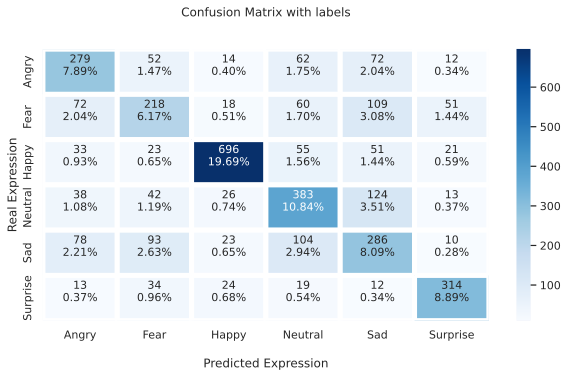

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

The accuracy on the test set is 61.57% that is higher than the previous one. Anyway, as it is possible to observe, while the accuracy on the training is increased by more than 10% with respect to `Franet2`, the increase in the test set is less than 5%. The main problem of this model is the overfitting: there is more than a 20% of difference between the accuracy on the test and the one on the training. 

Looking at the $F_1 scores$ most of the values are increased. The result achieved for the class `happy` is satisfying, but as before, the result for the class `fear` is low. 
Another issue is the fact that (as before) lot of pictures are wrongly assigned to the class `sad` (especially pictures of `neutral` and `fear` classes). 

## <font color='#009acd'>**Franet4**</font>

Since the main problem of `Franet3` is overfitting in this new model the main changes will involve the increase of one maxpool layer. 

In [ ]:
conv1 = InputCon([64, 1, 48,48], [1, 6, 3, 1, 2])
print(conv1)
maxpool1 = max_pool(conv1)
print(maxpool1)

conv2 = InputCon(maxpool1, [6, 32, 3, 1, 1])
print(conv2)
maxpool2 = max_pool(conv2)
print(maxpool2)

conv3 = InputCon(maxpool2, [32, 64,3, 2, 0])
print(conv3)

conv4 = InputCon(conv3, [64, 128, 1, 1, 1])
print(conv4)
maxpool3 = max_pool(conv4)
print(maxpool3)

conv5 = InputCon(maxpool3, [128, 256, 1, 1, 1])
print(conv5)
maxpool4 = max_pool(conv5)
print(maxpool4)

Linear1 = Linear(maxpool4, 512)
print(Linear1)

[64, 6, 50, 50]
[64, 6, 25, 25]
[64, 32, 25, 25]
[64, 32, 12, 12]
[64, 64, 5, 5]
[64, 128, 7, 7]
[64, 128, 3, 3]
[64, 256, 5, 5]
[64, 256, 2, 2]
[1024, 512]


In [ ]:
class FraNet4(Module):
  def __init__(self):
    super(FraNet4, self).__init__()
    self.cnn_layers = Sequential(
        Conv2d(1, 6, kernel_size=3, stride=1, padding = 2),
        BatchNorm2d(6),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(6, 32, kernel_size=3, stride=1, padding = 1),
        BatchNorm2d(32),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),


        Conv2d(32, 64, 3,  stride=2, padding = 0),
        BatchNorm2d(64),
        ReLU(inplace=True),


        Conv2d(64, 128, 1,  stride=1, padding = 1),
        BatchNorm2d(128),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2),


        Conv2d(128, 256, 1,  stride=1, padding = 1),
        BatchNorm2d(256),
        ReLU(inplace=True),
        MaxPool2d(kernel_size=2, stride=2)
        )
    
    self.linear_layers = Sequential(
        Linear(1024, 512), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 
        nn.Linear(512, 256), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 
        nn.Linear(256, 128), 
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        nn.Linear(128, 64),
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        nn.Linear(64, 6)
        )
  # Defining the forward pass    
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
# defining the model
model4 = FraNet4()


loss_function = torch.nn.CrossEntropyLoss()
optimizer_FraNet = torch.optim.Adam(params =  model4.parameters(), lr = 10**(-4))

# Function to calcuate the accuracy of the model
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model4.to(device)

FraNet4(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride

In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model4.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500==0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model4(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model4.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model4(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.6389790992592683 Validation Loss: 1.6053190380334854 
 Train Accuracy: 31.938265286034884  Val Accuracy: 34.81460515142938
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.6046034530067925 Validation Loss: 1.618360853620938 
 Train Accuracy: 33.241466199456674  Val Accuracy: 34.163600339654685
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.5955050493067398 Validation Loss: 1.5704913075481142 
 Train Accuracy: 34.05645891570534  Val Accuracy: 36.965751485989244
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.5750115593374525 Validation Loss: 1.5687796111617769 
 Train Accuracy: 34.603724556084885  Val Accuracy: 37.07896971412397
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

The algorithm performs 150 epochs reaching a final accuracy in the training set equal to 75.70% and on the validation accuracy equal to 45.12%, therefore both are less than the results obtained in `Franet3`. Comparing the plots of of the accuracy of `Franet3` and `Franet4` is evident how the line of the training of the `Franet3` increses steeply until epoch 50, while the one of  `Franet4` rises slowly. The same happens for the validation line. Moreover, the values of both validation and training accuracy in `Franet3` strats from higher values (around 20%), while the ones of `Franet4` strats from around 30% accuracy, therefore, not only the final accuracy is lower, but also the difference between the initial and final is much smaller. In general, the changes applied to obtain a better model don't lead to an improvement in the model because, the accuracy is even lower than before and the overfitting is still present. 

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model4(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 45.16129032258065


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 71.19177920390567


In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.33      0.33      0.33       491
        Fear       0.34      0.34      0.34       528
       Happy       0.64      0.57      0.61       879
     Neutral       0.41      0.43      0.42       626
         Sad       0.35      0.37      0.36       594
    Surprise       0.61      0.64      0.62       416

    accuracy                           0.45      3534
   macro avg       0.44      0.45      0.44      3534
weighted avg       0.46      0.45      0.45      3534



As in the previous cases, the model significantly misclassified the class `Fear`, but in this case, also the $F_1 score$ of `Angry` is really small. The result on the test set is worse than `Franet3` as expected from the results on the validation set. 

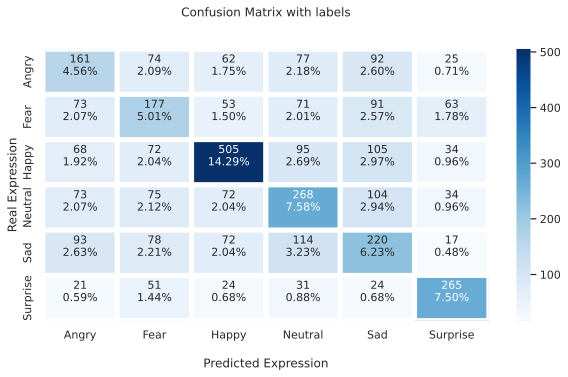

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

## <font color='#009acd'>**Franet5**</font>

Since, `Franet4` does not lead to any satisfying result, I go back to `Franet3` and try to improve it adding another convolutional layer, obtaining a model with 6 convolutional layers. To this end I needed to reduce the number of maxpool layers to 2. 

In [ ]:
conv1 = InputCon([64, 1, 48,48], [1, 6, 5, 1, 2])
print(conv1)

conv2 = InputCon(conv1, [6, 32, 3, 1, 1])
print(conv2)

maxpool2 = max_pool(conv2)
print(maxpool2)

conv3 = InputCon(maxpool2, [32, 64, 3, 1, 1])
print(conv3)

conv4 = InputCon(conv3, [64, 128, 3, 1,0])
print(conv4)

maxpool3 = max_pool(conv4)
print(maxpool3)

conv5 = InputCon(maxpool3, [128, 256, 3,  3, 0])
print(conv5)

conv6 = InputCon(conv5, [256, 512, 3,  1,  0])
print(conv6)


Linear1 = Linear(conv6, 2048)
print(Linear1)

[64, 6, 48, 48]
[64, 32, 48, 48]
[64, 32, 24, 24]
[64, 64, 24, 24]
[64, 128, 22, 22]
[64, 128, 11, 11]
[64, 256, 3, 3]
[64, 512, 1, 1]
[512, 2048]


In [ ]:
class FraNet5(Module):
  def __init__(self):
    super(FraNet5, self).__init__()
    self.cnn_layers = Sequential(
        # Defining a 2D convolution layer
        Conv2d(1, 6, kernel_size=5, stride=1, padding = 2),
        BatchNorm2d(6),
        ReLU(inplace=True),
        
        Conv2d(6, 32, kernel_size=3, stride=1, padding = 1),
        BatchNorm2d(32),
        ReLU(inplace=True),

        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(32, 64, 3,  stride=1, padding = 1),
        BatchNorm2d(64),
        ReLU(inplace=True),

        Conv2d(64, 128, 3,  stride=1, padding = 0),
        BatchNorm2d(128),
        ReLU(inplace=True),

        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(128, 256, 3,  stride=3, padding = 0),
        BatchNorm2d(256),
        ReLU(inplace=True),

        Conv2d(256, 512, 3,  stride=1, padding = 0),
        ReLU(inplace=True)
        )
    
    self.linear_layers = Sequential(
        Linear(512, 1024), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 
        nn.Linear(1024, 576), 
        nn.Dropout(p=0.5), 
        nn.ReLU(), 
        nn.Linear(576, 256), 
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        nn.Linear(256, 64),
        nn.Dropout(p=0.5),
        nn.ReLU(), 
        nn.Linear(64, 6)
        )
  # Defining the forward pass    
  def forward(self, x):
    x = self.cnn_layers(x)
    x = x.view(x.size(0), -1)
    x = self.linear_layers(x)
    return x

In [ ]:
# defining the model
model5 = FraNet5()

loss_function = torch.nn.CrossEntropyLoss()
optimizer_FraNet = torch.optim.Adam(params =  model5.parameters(), lr = 10**(-4))

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model5.to(device)

FraNet5(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3

In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model5.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500==0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model5(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model5.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model5(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7551524948413186 Validation Loss: 1.670787783605712 
 Train Accuracy: 21.398480255128156  Val Accuracy: 30.03113501273705
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.6158414430522199 Validation Loss: 1.538299920303481 
 Train Accuracy: 31.709909838970038  Val Accuracy: 37.24879705632607
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.497884897200827 Validation Loss: 1.4395637608000211 
 Train Accuracy: 38.5763219024371  Val Accuracy: 41.919048966883665
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.4321556938084907 Validation Loss: 1.4137237582887923 
 Train Accuracy: 41.71424071813851  Val Accuracy: 44.01358618737617
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

The model stops earlier at epoch 85 reaching a final accuracy on the triaining equal to 79.34% and on the validation equal to 56.92%. 

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model5(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 56.45161290322581


Also this model reaches worse results compared to `Franet3` and results very similar to `Franet2` but with higher complexity.  

In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 79.94802944997835


In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.50      0.51      0.50       491
        Fear       0.44      0.31      0.36       528
       Happy       0.75      0.76      0.76       879
     Neutral       0.48      0.57      0.52       626
         Sad       0.41      0.45      0.43       594
    Surprise       0.75      0.69      0.72       416

    accuracy                           0.56      3534
   macro avg       0.56      0.55      0.55      3534
weighted avg       0.57      0.56      0.56      3534



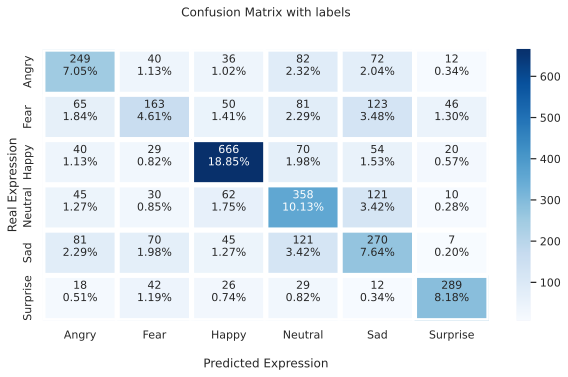

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

In genral, also this model seems to perform worse compared to`Franet3`, even if it is obtained increasing the complexity. 

## <font color='#009acd'>**Franet3 changing batch size**</font>

Since the pictures of the dataset are very small (48x48) it is not possible to increase much more the number of convolutional layers without using a lot of padding that would adds noise to the model.
For that reason I decide to focus the attention on `Franet3` and try, in the first case, to decrease the batch size (from 64 to 32) and in the second case changing optimizer in order to achieve better accuracy:   

In [ ]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle = True, 
                                               num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle = False, 
                                              num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle = False, 
                                                    num_workers=2)

In [ ]:
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)
validation_iter = iter(validation_dataloader)

In [ ]:
# defining the model
model3 = FraNet3()

loss_function = torch.nn.CrossEntropyLoss()
optimizer_FraNet = torch.optim.Adam(params =  model3.parameters(), lr = 10**(-4))

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3.to(device)

FraNet3(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3

In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model3.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500==0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model3(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model3.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model3(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 150
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7914146695389255 Validation Loss: 1.7496721379391782 
 Train Accuracy: 19.646442773337533  Val Accuracy: 21.85111803000283
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.6659405626337835 Validation Loss: 1.5516277573130153 
 Train Accuracy: 29.35548643647388  Val Accuracy: 37.05066515709029
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.5193362663915235 Validation Loss: 1.415915817290813 
 Train Accuracy: 38.11567384542698  Val Accuracy: 44.01358618737617
-.-.-.-.-.

The model, after 150 epochs reaches an accuracy on the training set equal to 84.33% that is smaller than the ofe of `Franet3` with batch size 64. The accuracy on the validation is 60.91%.

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model3(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 62.11092246745897


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 84.93247765660065


The accuracy on the test set is the highest reached until now, it is 62.11%. In general, smaller batch size leads to best generalization performance, even if it tend to be slower convergence. 
Looking at the values of the $F_1 score$ the results don't outperform the ones of the model with batchsize 64. Moreover, as before the model seems to have problems in recognising the picture of the class `fear`.

In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.55      0.52      0.53       491
        Fear       0.47      0.43      0.45       528
       Happy       0.82      0.79      0.81       879
     Neutral       0.57      0.64      0.61       626
         Sad       0.48      0.50      0.49       594
    Surprise       0.75      0.78      0.77       416

    accuracy                           0.62      3534
   macro avg       0.61      0.61      0.61      3534
weighted avg       0.62      0.62      0.62      3534



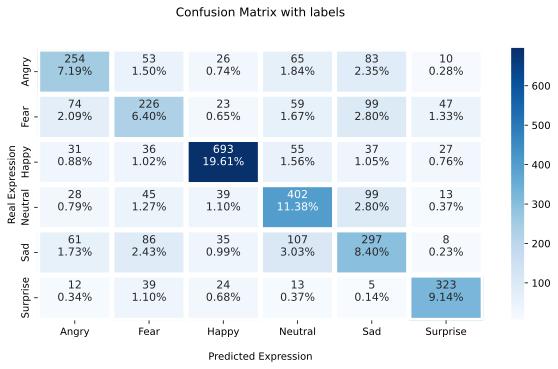

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

## <font color='#009acd'>**Franet3 changing optimizer**</font>

The optimizer used in the previous model was Adam that in this case will be substituted by the Stochastic Gradient Descent optimizer. (Using again batch size = 64). 
In general, SGD should generalizes more than Adam but could also need more time to reach good results. For that reason I decide to increase the number of maximum epoch in this case to 200. 

In [ ]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle = True, 
                                               num_workers=2)#256
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle = False, 
                                              num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, 
                                                    batch_size=batch_size, 
                                                    shuffle = False, 
                                                    num_workers=2)

In [ ]:
train_iter = iter(train_dataloader)
test_iter = iter(test_dataloader)
validation_iter = iter(validation_dataloader)

In [ ]:
# defining the model
model3 = FraNet3()

loss_function = torch.nn.CrossEntropyLoss()
optimizer_FraNet = torch.optim.SGD(model3.parameters(), lr=10**(-4), momentum=0.99)

#Instantiating CUDA device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3.to(device)

FraNet3(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3

In [ ]:
# Function to save the model 
def saveModel(): 
    path = "./NetModel.pth" 
    torch.save(model3.state_dict(), path) 

In [ ]:
def train(num_epochs): 
    best_accuracy = 0.0 
    epoch_accu_FraNet = []
    epoch_loss_FraNet = []
    valid_accu_FraNet=[]
    valid_loss_FraNet = []
     
    for epoch in range(1, num_epochs+1): 
        running_train_loss = 0.0 
        running_accuracy = 0.0 
        running_vall_loss = 0.0 
        total = 0 
        nb_tr_steps = 0
        n_correct = 0
        nb_tr_examples = 0
 

        for i, data in enumerate(train_dataloader, 0): 
            if i % 500==0:
              print("-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-")
            inputs, outputs = data[0].to(device), data[1].to(device)  # get the input and real species as outputs; data is a list of [inputs, outputs] 
            optimizer_FraNet.zero_grad()   # zero the parameter gradients          
            
            predicted_outputs = model3(inputs)   # predict output from the model 
            train_loss = loss_function(predicted_outputs, outputs)   # calculate loss for the predicted output  
            train_loss.backward()   # backpropagate the loss 
            optimizer_FraNet.step()   
                 # adjust parameters based on the calculated gradients 
            running_train_loss += train_loss.item()  # track the loss value 
            
            nb_tr_steps += 1
            big_val, big_idx = torch.max(predicted_outputs.data, dim=1)        
            n_correct += (big_idx==outputs).sum().item()
            nb_tr_examples+=outputs.size(0)
 
        # Calculate training loss value 
        train_loss_value = running_train_loss/len(train_dataloader) 
        train_accu = n_correct * 100/nb_tr_examples
 
        # Validation Loop 
        with torch.no_grad(): 
            model3.eval() 
            for data, target in validation_dataloader: 
               inputs, outputs = data.cuda(), target.cuda()
               predicted_outputs = model3(inputs) 
               val_loss = loss_function(predicted_outputs, outputs) 
             
               # The label with the highest value will be our prediction 
               _, predicted = torch.max(predicted_outputs, 1) 
               running_vall_loss += val_loss.item()  
               total += outputs.size(0) 
               running_accuracy += (predicted == outputs).sum().item() 
 
        # Calculate validation loss value 
        val_loss_value = running_vall_loss/len(validation_dataloader) 
                
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
        accuracy = (100 * running_accuracy / total)     
 
        # Save the model if the accuracy is the best 
        if accuracy > best_accuracy: 
            saveModel() 
            best_accuracy = accuracy 
         
        # Print the statistics of the epoch 
        print('EPOCH', epoch, ' \n Training Loss:', train_loss_value, 'Validation Loss:', val_loss_value, '\n Train Accuracy:',train_accu, ' Val Accuracy:', accuracy)
        
        epoch_accu_FraNet.append(train_accu)
        epoch_loss_FraNet.append(train_loss_value)
        valid_accu_FraNet.append(accuracy)
        valid_loss_FraNet.append(val_loss_value)

        #Early Stopping
        if epoch > 2:
          if abs(epoch_accu_FraNet[epoch-2] - epoch_accu_FraNet[epoch-1]) < 0.000001:
            print("\nEarly stopping. Epoch:", epoch)
            break 

    return epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet


In [ ]:
%%time
epochs= 200
epoch_accu_FraNet,epoch_loss_FraNet,valid_accu_FraNet,valid_loss_FraNet= train(epochs)

-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 1  
 Training Loss: 1.7853563447443004 Validation Loss: 1.7596055822713035 
 Train Accuracy: 18.80782707980629  Val Accuracy: 24.681573733371074
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 2  
 Training Loss: 1.7446253990346299 Validation Loss: 1.7231667573962892 
 Train Accuracy: 23.099334619473208  Val Accuracy: 27.030851967166715
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 3  
 Training Loss: 1.6896635828450586 Validation Loss: 1.6200982161930628 
 Train Accuracy: 29.01295326587661  Val Accuracy: 35.437305406170395
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-
EPOCH 4  
 Training Loss: 1.6028323251594525 Validation Loss: 1.5220564816679274 
 Train Accuracy: 33.898972400488205  Val Accuracy: 39.23011604868384
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-

The accuracy results obtained are the following: 

- Epoch 150th: 

 *   Training: 87.0861%
 *   Validation: 62.9493%

- Epoch 200th:

 *   Training: 88.6924%
 *   Validation: 63.0059%

The difference, most of all in the validation accuracy, is almost imperceptible comparing the results at the 200th and at the 150th epoch. 



In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))), 
                         y=epoch_loss_FraNet, line_color='#2A87BC',
                         mode='lines+markers', 
                         name='Training Loss'))
fig.add_trace(go.Scatter(x=list(range(len(epoch_loss_FraNet))),
                         y=valid_loss_FraNet, line_color='#37D5E4',
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_yaxes(range=[0, 3])
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(epoch_accu_FraNet))), mode='lines+markers',line_color='#2A87BC',
                         y=epoch_accu_FraNet, name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(range(len(valid_accu_FraNet))), y=valid_accu_FraNet,
                    mode='lines+markers',line_color='#37D5E4',
                    name='Validation Accuracy'))
fig.update_yaxes(range=[10, 100])
fig.show()

In [ ]:
# Testing the model
def test_FraNet(testing_loader):
  correct = 0
  total = 0
  predicted_class = []
  true_class = []
  with torch.no_grad():
    for data in testing_loader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs = model3(images)
      _, predicted = torch.max(outputs.data, 1)
      temp_pred = np.array(predicted.cpu())
      temp_lab = np.array(labels.cpu())
      for i in range(len(predicted)):
        predicted_class.append(temp_pred[i])
        true_class.append(temp_lab[i])
      
      total += labels.size(0)  
      correct += (predicted == labels).sum().item()
  print("Accuracy of the network on the test images:", (100 * correct / total))
  return predicted_class, true_class

predicted_classes_FraNet, true_classes_FraNet = test_FraNet(test_dataloader)

Accuracy of the network on the test images: 63.1578947368421


In [ ]:
predicted_classes_FraNet1, true_classes_FraNet1 = test_FraNet(train_dataloader)

Accuracy of the network on the test images: 89.1294932871373


The accuracy on the test set is equal to 63.16% that is slightly higher than before. The results on the `F_1 score` are similar to the ones of `Franet3` with adam optimizer. As before, the confusion matrix shows that most of the images are correctly classified but there are still a lot of misclassifications for the class `fear`. 

In [ ]:
print(classification_report(np.transpose(true_classes_FraNet), np.transpose(predicted_classes_FraNet),target_names=class_names))

              precision    recall  f1-score   support

       Angry       0.58      0.55      0.56       491
        Fear       0.48      0.51      0.49       528
       Happy       0.86      0.80      0.83       879
     Neutral       0.58      0.62      0.60       626
         Sad       0.48      0.45      0.46       594
    Surprise       0.72      0.81      0.77       416

    accuracy                           0.63      3534
   macro avg       0.62      0.62      0.62      3534
weighted avg       0.63      0.63      0.63      3534



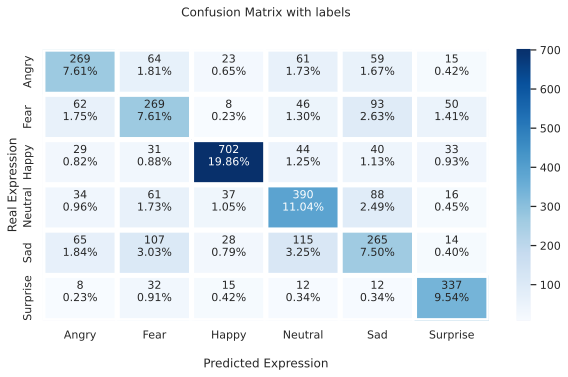

In [ ]:
Confusion_matrix(true_classes_FraNet, predicted_classes_FraNet)

## <font color='#009acd'>**Conclusions**</font>

Considering all the models implemented in this project the best one is surely the `Franet3`. Anyway, also this model doesn't reach a satisfying level of accuracy because on the test set it reaches a maximum of 63% of accuracy. 
Between the 3 different cases of implementation of `Franet3` there is not much difference, so probably I would still use the `Franet3` with batch size = 64 and Adam Optimizer since the others are slower. 

These results are probably due to the fact that, as I mentioned before, the expressions are not something objective, also a human being looking at the photos can confuse one expression with another. 
Even if the training set of the class `fear` wasn't the smallest one, it was the class the model find most difficult to recognize and probably the reason is that in a lot of cases the pictures of a sad person is not that different from a frightened one. And this can be shown with the pictures shown below. The pictures below also show some examples that were wrongly classified (from my point of view) in the given dataset.

Another issue of this dataset is the fact that the size of the images is really small and therefore it is impossible to apply many convolutional layers and probably also the information obtained by each picture is smaller compared to an identical photo but with a higher definition. 

On the other hand, the results of the class `happy` are quite good also for the test set and can be considered satisfactory. 

In general, the results obtained on the training set were quite high but all the models (except `Franet1`) considered in this project tend to overfit the data of the training set, in fact, there was always a discrepancy between the two accuracies. 

Probably the model can be improved using more pictures to train the model, increasing data augmentation and trying to reduce even more the batch size. Moreover, it could be useful to perform others changes in the hyperparameters to find the best tuning.

FEAR IMAGES IN THE TEST SET


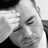

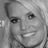

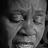

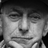


SAD IMAGES IN THE TRAINING SET


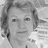

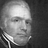

In [ ]:
print("FEAR IMAGES IN THE TEST SET")
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Fear/2_32458.png', width = 150))
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Fear/2_32283.png', width = 150))
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Fear/2_31911.png', width = 150))
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/Test/Fear/2_31908.png', width = 150))
print("\nSAD IMAGES IN THE TRAINING SET")
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Sad/4_16274.png', width = 150))
display(Image(filename='/content/drive/MyDrive/PROGETTO_ADVANCE/Training/Sad/4_20276.png', width = 150))